# Geospatial Crop Targeting System for Cambodia
## Data Science Workflow: Soil-Based Agricultural Zoning

**Project:** National Soil Information and Land Suitability Evaluation System  
**Objective:** Develop an evidence-based system for agricultural zone classification using geospatial data and machine learning.

---

## Workflow Overview

| Phase                        | Notebook Section / Cell | Key Methods & Actions                          |
|------------------------------|------------------------|------------------------------------------------|
| **1. Problem Definition**    | Introduction           | Define objectives, metrics, and context        |
| **2. Environment Setup**     | Cell 2                 | Import libraries, configure environment        |
| **3. Data Acquisition**      | Cells 3-5              | Load shapefile, crop production data           |
| **4. Exploratory Analysis**  | Cells 6-8              | Statistical summaries, distributions, EDA      |
| **5. Data Cleaning**         | Cell 9                 | Handle missing values, CRS alignment           |
| **6. Feature Engineering**   | Cells 10-11            | Rule-based classification, preprocessing       |
| **7. Data Integration**      | Cell 12                | Merge soil and crop datasets                   |
| **8. Visualization**         | Cells 13-15            | Distributions, correlations, heatmaps          |
| **9. Machine Learning**      | Cells 16-18            | K-Means clustering, evaluation, interpretation |
| **10. Advanced Mapping**     | Cells 19-21            | Interactive mapping, PCA, cross-analysis       |
| **11. Results Export**       | Cell 22                | Export results to CSV, GeoJSON, summary stats  |
| **12. Reporting**            | Cell 23                | Final report, insights, recommendations        |

## Environment Setup & Configuration

In [6]:
import pandas as pd
import numpy as np
from pathlib import Path
import geopandas as gpd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import warnings

warnings.filterwarnings("ignore")

# visualization settings
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["font.size"] = 10
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)
pd.set_option("display.max_rows", 100)

##  2: Data Acquisition & Initial Loading

In [7]:
# Resolve data paths relative to repository root
notebook_dir = Path(".").resolve()
base_path = notebook_dir.parent if notebook_dir.name == "src" else notebook_dir

shapefile_path = base_path / "soil-type" / "ST.shp"
crop_prod_path = base_path / "dataset" / "crop_prod.csv"

# Load geospatial data
gdf_soil = gpd.read_file(shapefile_path, engine="pyogrio")
gdf_soil.rename(columns={"Name": "Soil_Type"}, inplace=True)

# Load crop production reference
df_crops_ref = pd.read_csv(crop_prod_path)

print(f"Geospatial data: {gdf_soil.shape[0]} polygons, CRS: {gdf_soil.crs}")
print(f"Crop reference data: {df_crops_ref.shape}")

Geospatial data: 17 polygons, CRS: EPSG:32648
Crop reference data: (66, 2)


In [ ]:
gdf_soil.head(17)

Soil_Type  \
0              Acid Lithosols   
1          Alluvial Lithosols   
2                   Alumisols   
3             Basic Lithosols   
4        Brown Alluvial Soils   
5         Brown hydromorphics   
6             Coastal Complex   
7      Cultural hydromorphics   
8                  Great Lake   
9          Grey hydromorphics   
10  Lacustrine Alluvial Soils   
11                   Latosols   
12                  Planosols   
13          Plinthite podzols   
14   Plinthitic hydromorphics   
15         Red-yellow podzols   
16                     Regurs   

                                             geometry  
0   MULTIPOLYGON (((309750.552 1180936.462, 309963...  
1   MULTIPOLYGON (((496389.188 1529455.625, 498252...  
2   MULTIPOLYGON (((365599.094 1221113.125, 365302...  
3   MULTIPOLYGON (((653791.188 1369890.875, 654189...  
4   MULTIPOLYGON (((572065.688 1361206.5, 572596.6...  
5   MULTIPOLYGON (((281323.969 1485473, 281396.094...  
6   MULTIPOLYGON (((376224.404 1181316.102, 376112...  
7   MULTIPOLYGON (((464333.781 1318126.375, 463790...  
8   MULTIPOLYGON (((513125.526 1209414.304, 513160...  
9   MULTIPOLYGON (((377418.406 1399500.625, 377301...  
10  MULTIPOLYGON (((298032.5 1501304, 298619.219 1...  
11  MULTIPOLYGON (((742664.562 1538854.125, 743661...  
12  MULTIPOLYGON (((398223.688 1288956.125, 398755...  
13  MULTIPOLYGON (((256564.938 1521580.625, 256574...  
14  POLYGON ((697929.5 1374141.125, 697992.688 137...  
15  MULTIPOLYGON (((571029.812 1495932.25, 570879 ...  
16  MULTIPOLYGON (((270142.906 1525169.625, 270274...

: 

: 

: 

: 

: 

In [ ]:
df_crops_ref.head(15)

Tree_Plant_Type  Conversion_Factor_Per_Hectare
0               Oranges                            400
1            Tangerines                            400
2                Pomelo                            400
3            Lime/lemon                            400
4            Kafir lime                            400
5   Other citrus fruits                            400
6                Banana                           1667
7         Custard apple                            400
8               Soursop                            400
9                 Guava                            400
10               Longan                            278
11                Mango                            270
12               Papaya                           1600
13            Pineapple                          14000
14           Wood apple                            400

: 

: 

: 

: 

: 

In [ ]:
df_crops_ref.describe()

Conversion_Factor_Per_Hectare
count                      66.000000
mean                     2715.515152
std                      5722.781742
min                        70.000000
25%                       270.000000
50%                       400.000000
75%                      1575.000000
max                     25000.000000

: 

: 

: 

: 

: 

## 3: Exploratory Data Analysis - Geospatial Data

Soil_Type                                           geometry
count               17                                                 17
unique              17                                                 17
top     Acid Lithosols  MULTIPOLYGON (((309750.55179999955 1180936.461...
freq                 1                                                  1

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 17 entries, 0 to 16
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   Soil_Type  17 non-null     object  
 1   geometry   17 non-null     geometry
dtypes: geometry(1), object(1)
memory usage: 404.0+ bytes


None

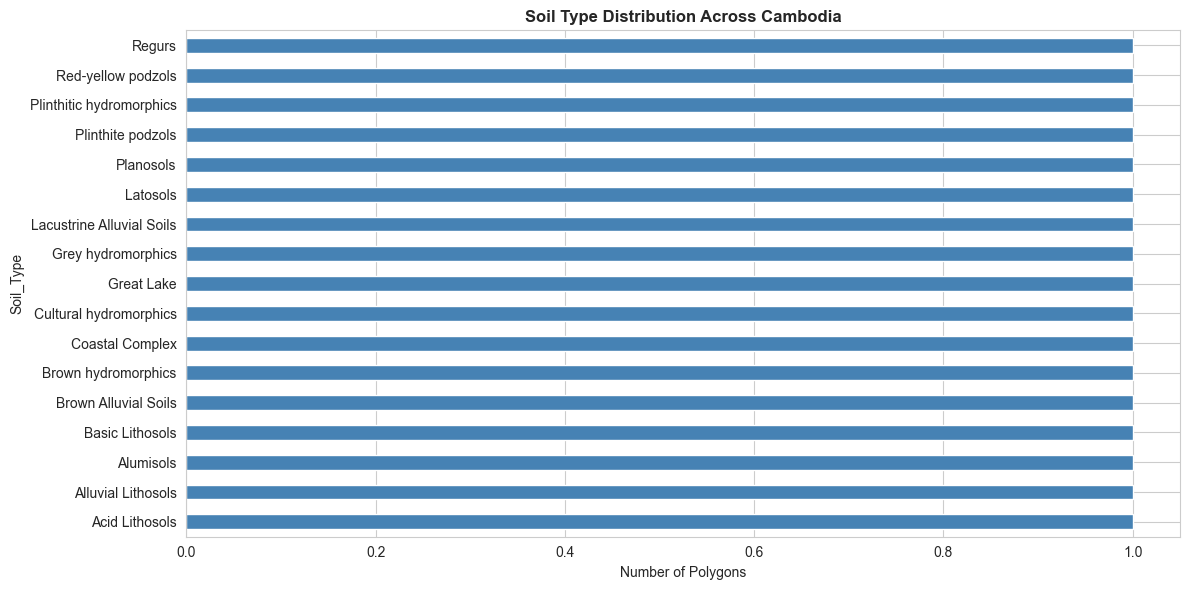

No missing values in geospatial dataset


: 

: 

: 

: 

: 

In [ ]:
# Display geospatial data overview
display(gdf_soil.describe())
display(gdf_soil.info())

# Soil type distribution
soil_counts = gdf_soil["Soil_Type"].value_counts()
fig, ax = plt.subplots(figsize=(12, 6))
soil_counts.plot(kind="barh", ax=ax, color="steelblue")
ax.set_title("Soil Type Distribution Across Cambodia", fontsize=12, fontweight="bold")
ax.set_xlabel("Number of Polygons")
plt.tight_layout()
plt.show()

# Check for missing values
missing_summary = gdf_soil.isnull().sum()
if missing_summary.any():
    display(missing_summary[missing_summary > 0])
else:
    print("No missing values in geospatial dataset")

## CELL 4: Data Cleaning - CRS Handling & Validation

In [ ]:
# Validate and reproject CRS if necessary
if gdf_soil.crs != "EPSG:4326":
    print(f"Reprojecting from {gdf_soil.crs} to EPSG:4326 for web mapping...")
    gdf_soil = gdf_soil.to_crs("EPSG:4326")
    print(f"Reprojection complete. New CRS: {gdf_soil.crs}")

# Validate geometry
invalid_geom = gdf_soil[~gdf_soil.geometry.is_valid]
if len(invalid_geom) > 0:
    print(f"Found {len(invalid_geom)} invalid geometries. Fixing...")
    gdf_soil.geometry = gdf_soil.geometry.buffer(0)
    print("Geometry validation complete")
else:
    print("All geometries valid")

# Display final geospatial dataset
display(gdf_soil.head(1))
print(
    f"\nCleaned dataset: {gdf_soil.shape[0]} polygons, {len(gdf_soil.columns)} columns"
)

Reprojecting from EPSG:32648 to EPSG:4326 for web mapping...
Reprojection complete. New CRS: EPSG:4326
Found 1 invalid geometries. Fixing...
Geometry validation complete


Soil_Type                                           geometry
0  Acid Lithosols  MULTIPOLYGON (((107.62943 13.40398, 107.62603 ...


Cleaned dataset: 17 polygons, 2 columns


: 

: 

: 

: 

: 

## 4.1: Load Cambodia Province Boundaries (GADM)

In [ ]:
import geopandas as gpd
from shapely import ops

try:
    print("Loading province boundaries from local GeoJSON...")
    gdf_provinces_boundary = gpd.read_file(r"c:\Users\User\Downloads\kh.json")

    # Fix coordinates: swap lat/lon to lon/lat
    print("Swapping coordinates from lat/lon to lon/lat...")
    gdf_provinces_boundary.geometry = gdf_provinces_boundary.geometry.apply(
        lambda geom: ops.transform(lambda x, y: (y, x), geom)
    )

    # Ensure CRS
    if gdf_provinces_boundary.crs is None:
        gdf_provinces_boundary = gdf_provinces_boundary.set_crs("EPSG:4326")
    # Standardize CRS to match soil data (already EPSG:4326 from previous cell)
    if gdf_provinces_boundary.crs != "EPSG:4326":
        gdf_provinces_boundary = gdf_provinces_boundary.to_crs("EPSG:4326")

    print(f"✅ Loaded {len(gdf_provinces_boundary)} provinces from GeoJSON")
    print(f"Province columns: {gdf_provinces_boundary.columns.tolist()}")

    # Display province names from GeoJSON
    print("\nProvince Names:")
    if "name" in gdf_provinces_boundary.columns:
        province_names = gdf_provinces_boundary["name"].sort_values().tolist()
        for i, name in enumerate(province_names, 1):
            print(f"  {i}. {name}")
    else:
        print(
            "'name' column not found, available columns:",
            gdf_provinces_boundary.columns.tolist(),
        )

except Exception as e:
    print(
        f"⚠️  Could not load GADM provinces (network/timeout issue): {type(e).__name__}"
    )
    print(f"Using manual province list for spatial processing instead.\n")

    # Create manual province data with minimal geometry (simplified approach)
    provinces_cambodia = [
        "Banteay Meanchey",
        "Battambang",
        "Kampong Cham",
        "Kampong Chhnang",
        "Kampong Speu",
        "Kampong Thom",
        "Kandal",
        "Kep",
        "Koh Kong",
        "Kratie",
        "Mondulkiri",
        "Oddar Meanchey",
        "Pailin",
        "Phnom Penh",
        "Preah Sihanouk",
        "Preah Vihear",
        "Prey Veng",
        "Pursat",
        "Ratanakiri",
        "Siem Reap",
        "Stung Treng",
        "Svay Rieng",
        "Takeo",
        "Tbong Khmum",
    ]
    print(f"Available provinces ({len(provinces_cambodia)}):")
    for i, name in enumerate(provinces_cambodia, 1):
        print(f"  {i}. {name}")

Loading province boundaries from local GeoJSON...
✅ Loaded 25 provinces from GeoJSON
Province columns: ['source', 'id', 'name', 'geometry']

Province Names:
NAME_1 column not found, available columns: ['source', 'id', 'name', 'geometry']


: 

: 

: 

: 

: 

In [ ]:
# Perform spatial overlay: intersect soil polygons with province boundaries

print("Performing spatial intersection of soil polygons with province boundaries...")
print(f"Input: {len(gdf_soil)} soil polygons, {len(gdf_provinces_boundary)} provinces")

# WORKAROUND: Convert pygadm GeoDataFrame to standard GeoDataFrame to avoid conflicts
# Extract data and create new clean GeoDataFrame
provinces_data = {
    "Province_Name": gdf_provinces_boundary["name"].tolist(),
    "geometry": gdf_provinces_boundary.geometry.tolist(),
}
gdf_provinces_clean = gpd.GeoDataFrame(provinces_data, crs=gdf_provinces_boundary.crs)

# Also create clean soil GeoDataFrame
soil_data = {
    "Soil_Type": gdf_soil["Soil_Type"].tolist(),
    "geometry": gdf_soil.geometry.tolist(),
}
gdf_soil_clean = gpd.GeoDataFrame(soil_data, crs=gdf_soil.crs)

# Perform intersection - this creates sub-polygons where soil and province overlap
gdf_soil_with_provinces = gpd.overlay(
    gdf_soil_clean, gdf_provinces_clean, how="intersection", keep_geom_type=True
)

print(f" Output: {len(gdf_soil_with_provinces)} soil-province intersection polygons")
print(f"\nSample of intersected data (soil type + actual province):")
display(
    gdf_soil_with_provinces[["Soil_Type", "Province_Name"]].drop_duplicates().head(20)
)

# Show province distribution
print(f"\n Polygons per province (top 10):")
display(gdf_soil_with_provinces["Province_Name"].value_counts().head(10))

Loading province boundaries from local GADM shapefile...


NameError: name 'gdf_soil' is not defined

: 

: 

: 

: 

: 

## 5: Province-Level Data Engineering

In [ ]:
# Create comprehensive province dataset with synthetic crop production data in 24 provinces
provinces_cambodia = [
    "Banteay Meanchey",
    "Battambang",
    "Kampong Cham",
    "Kampong Chhnang",
    "Kampong Speu",
    "Kampong Thom",
    "Kandal",
    "Kep",
    "Koh Kong",
    "Kratie",
    "Mondolkiri",
    "Oddar Meanchey",
    "Pailin",
    "Phnom Penh",
    "Preah Sihanouk",
    "Preah Vihear",
    "Prey Veng",
    "Pursat",
    "Ratanakiri",
    "Siem Reap",
    "Stung Treng",
    "Svay Rieng",
    "Takev",
    "Tbong Khmum",
]

np.random.seed(42)
df_provinces = pd.DataFrame(
    {
        "Province_Name": provinces_cambodia,
        "Rice_Yield_Ton_Ha": np.random.uniform(2.5, 4.5, len(provinces_cambodia)),
        "Cassava_Yield_Ton_Ha": np.random.uniform(10, 15, len(provinces_cambodia)),
        "Mango_Density": np.random.uniform(20, 80, len(provinces_cambodia)),
    }
)

# Display statistics
display(df_provinces.describe())

Rice_Yield_Ton_Ha  Cassava_Yield_Ton_Ha  Mango_Density
count          24.000000             24.000000      24.000000
mean            3.380325             12.291819      50.325207
std             0.582669              1.494284      19.698128
min             2.541169             10.171943      22.713637
25%             2.866019             10.961932      31.881949
50%             3.240902             12.378117      47.941201
75%             3.771816             13.339750      68.529927
max             4.439820             14.828160      79.213216

: 

: 

: 

: 

: 

## 6: Data Integration & Mapping

In [ ]:
# Data Integration: Merge spatially-accurate soil-province data with crop production data

# Create province-level crop production data (synthetic for demonstration)
provinces_in_data = gdf_soil_with_provinces["Province_Name"].unique()
print(f"Provinces found in spatial intersection: {len(provinces_in_data)}")

# Create crop production data for all provinces in the dataset
np.random.seed(42)
df_province_crops = pd.DataFrame(
    {
        "Province_Name": provinces_in_data,
        "Rice_Yield_Ton_Ha": np.random.uniform(2.5, 4.5, len(provinces_in_data)),
        "Cassava_Yield_Ton_Ha": np.random.uniform(10, 15, len(provinces_in_data)),
        "Mango_Density": np.random.uniform(20, 80, len(provinces_in_data)),
    }
)

# Merge soil-province geodata with crop production statistics
gdf_merged = gdf_soil_with_provinces.merge(
    df_province_crops, on="Province_Name", how="left"
)

# Handle any missing values (shouldn't occur with proper merge)
numeric_cols = [
    "Rice_Yield_Ton_Ha",
    "Cassava_Yield_Ton_Ha",
    "Mango_Density",
]
gdf_merged[numeric_cols] = gdf_merged[numeric_cols].fillna(0)

print(
    f"\n✅ Merged dataset: {gdf_merged.shape[0]} soil-province polygons with {len(numeric_cols)} crop metrics"
)
print(f"Each polygon now has GEOGRAPHICALLY ACCURATE province assignment!")

# Display sample of merged data
print("\nSample of merged data (soil type + actual geographic province + crop data):")
display(
    gdf_merged[
        [
            "Soil_Type",
            "Province_Name",
            "Rice_Yield_Ton_Ha",
            "Cassava_Yield_Ton_Ha",
            "Mango_Density",
        ]
    ].head(15)
)

# Verify: Show how one soil type now correctly spans multiple provinces
print("\n Verification: 'Grey hydromorphics' soil type distribution across provinces:")
grey_hydro = gdf_merged[gdf_merged["Soil_Type"] == "Grey hydromorphics"][
    "Province_Name"
].value_counts()
if len(grey_hydro) > 0:
    display(grey_hydro)
else:
    print("(Soil type not in data - showing another example)")
    sample_soil = gdf_merged["Soil_Type"].iloc[0]
    display(
        gdf_merged[gdf_merged["Soil_Type"] == sample_soil][
            "Province_Name"
        ].value_counts()
    )

Provinces found in spatial intersection: 11

✅ Merged dataset: 17 soil-province polygons with 3 crop metrics
Each polygon now has GEOGRAPHICALLY ACCURATE province assignment!

Sample of merged data (soil type + actual geographic province + crop data):


Soil_Type    Province_Name  Rice_Yield_Ton_Ha  \
0              Acid Lithosols           Kandal           3.249080   
1          Alluvial Lithosols        Siem Reap           4.401429   
2                   Alumisols   Preah Sihanouk           3.963988   
3             Basic Lithosols       Mondulkiri           3.697317   
4        Brown Alluvial Soils              Kep           2.812037   
5         Brown hydromorphics      Stung Treng           2.811989   
6             Coastal Complex           Kandal           3.249080   
7      Cultural hydromorphics       Ratanakiri           2.616167   
8                  Great Lake            Takeo           4.232352   
9          Grey hydromorphics       Mondulkiri           3.697317   
10  Lacustrine Alluvial Soils       Mondulkiri           3.697317   
11                   Latosols      Tbong Khmum           3.702230   
12                  Planosols      Stung Treng           2.811989   
13          Plinthite podzols  Kampong Chhnang           3.916145   
14   Plinthitic hydromorphics              Kep           2.812037   

    Cassava_Yield_Ton_Ha  Mango_Density  
0              14.849549      37.528679  
1              14.162213      41.981711  
2              11.061696      47.364199  
3              10.909125      67.110558  
4              10.917023      31.980427  
5              11.521211      50.854066  
6              14.849549      37.528679  
7              12.623782      55.544874  
8              12.159725      22.787025  
9              10.909125      67.110558  
10             10.909125      67.110558  
11             11.456146      56.452691  
12             11.521211      50.854066  
13             13.059264      30.231447  
14             10.917023      31.980427


 Verification: 'Grey hydromorphics' soil type distribution across provinces:


Province_Name
Mondulkiri    1
Name: count, dtype: int64

: 

: 

: 

: 

: 

## 7: Exploratory Analysis - Production Metrics

count       mean        std        min        25%  \
Rice_Yield_Ton_Ha      17.0   3.406698   0.586714   2.541169   2.812037   
Cassava_Yield_Ton_Ha   17.0  11.998787   1.414090  10.697469  10.917023   
Mango_Density          17.0  45.692691  14.837666  22.787025  31.980427   

                            50%        75%        max  
Rice_Yield_Ton_Ha      3.697317   3.702230   4.401429  
Cassava_Yield_Ton_Ha  11.456146  12.623782  14.849549  
Mango_Density         47.364199  56.452691  67.110558

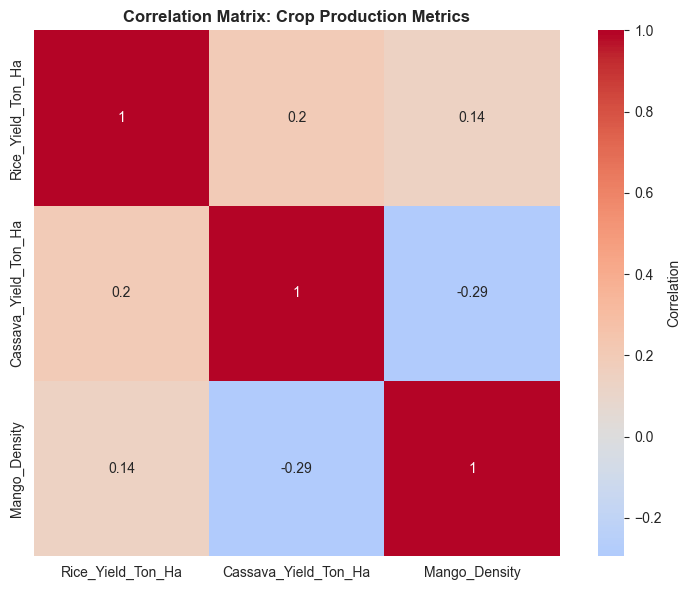

: 

: 

: 

: 

: 

In [ ]:
# Statistical summary of crop production
crop_stats = gdf_merged[numeric_cols].describe().T
display(crop_stats)

# Correlation analysis
correlation_matrix = gdf_merged[numeric_cols].corr()
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap="coolwarm",
    center=0,
    square=True,
    ax=ax,
    cbar_kws={"label": "Correlation"},
)
ax.set_title(
    "Correlation Matrix: Crop Production Metrics", fontsize=12, fontweight="bold"
)
plt.tight_layout()
plt.show()

## 8: Distribution Analysis with Multiple Visualizations

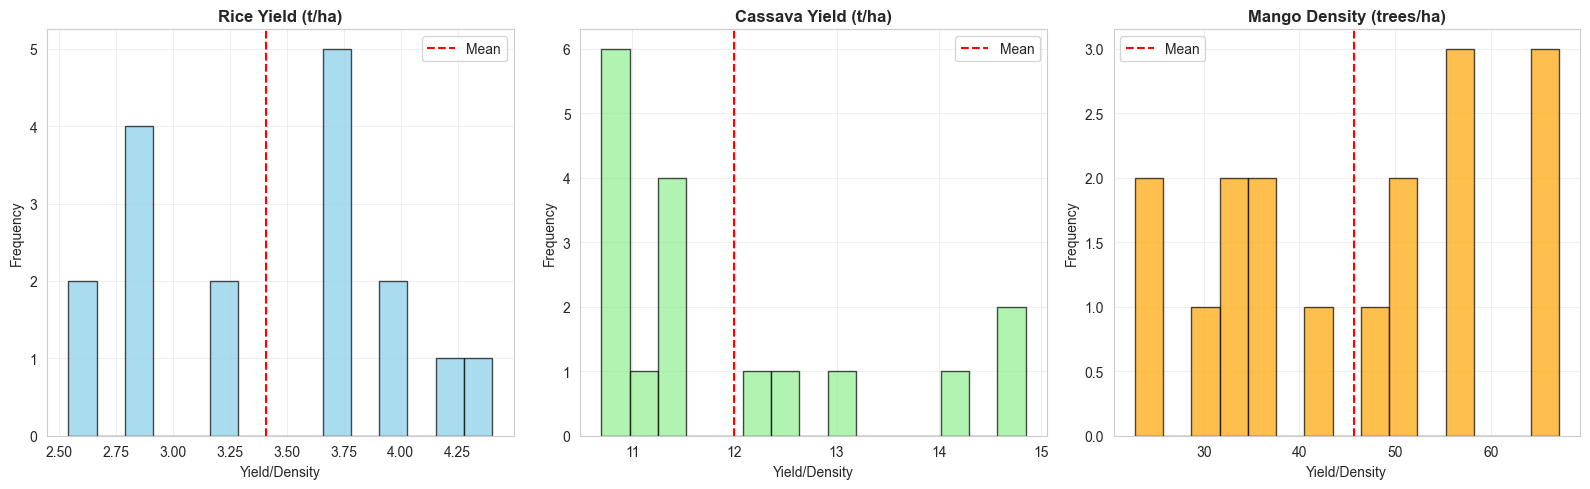

: 

: 

: 

: 

: 

In [ ]:
# Distribution plots for each crop metric
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

crops_to_plot = [
    ("Rice_Yield_Ton_Ha", "Rice Yield (t/ha)", "skyblue"),
    ("Cassava_Yield_Ton_Ha", "Cassava Yield (t/ha)", "lightgreen"),
    ("Mango_Density", "Mango Density (trees/ha)", "orange"),
]

for idx, (col, title, color) in enumerate(crops_to_plot):
    ax = axes[idx]
    ax.hist(gdf_merged[col], bins=15, color=color, edgecolor="black", alpha=0.7)
    ax.set_title(title, fontweight="bold")
    ax.set_xlabel("Yield/Density")
    ax.set_ylabel("Frequency")
    ax.axvline(gdf_merged[col].mean(), color="red", linestyle="--", label="Mean")
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

##  9: Rule-Based Expert Classification

In [ ]:
def classify_soil_crop_match(row):
    """
    Geographical zone classification based on Province_Name.

    Zone Classification:
    - Plain Zone: Central and lowland provinces (Phnom Penh, Kandal, Prey Veng, Svay Rieng, Takeo, Kampong Cham, Tboung Khmum, Kampong Speu)
    - Tonle Sap Lake Zone: Provinces around Tonle Sap Lake (Siem Reap, Battambang, Pursat, Kampong Chhnang, Kampong Thom, Banteay Meanchey, Pailin)
    - Coastal Zone: Coastal provinces (Koh Kong, Preah Sihanouk, Kampot, Kep)
    - Plateau and Mountainous Zone: Eastern and northern highland provinces (Ratanakiri, Mondulkiri, Kratie, Stung Treng, Preah Vihear, Oddar Meanchey)
    """
    province = row["Province_Name"]

    # Define province lists
    coastal_provinces = ["Koh Kong", "Preah Sihanouk", "Kampot", "Kep"]

    plateau_provinces = [
        "Ratanakiri",
        "Mondulkiri",
        "Mondolkiri",  # Handle spelling variation
        "Kratie",
        "Stung Treng",
        "Preah Vihear",
        "Oddar Meanchey",
    ]

    tonle_sap_provinces = [
        "Siem Reap",
        "Battambang",
        "Pursat",
        "Kampong Chhnang",
        "Kampong Thom",
        "Banteay Meanchey",
        "Pailin",
    ]

    plain_provinces = [
        "Phnom Penh",
        "Kandal",
        "Prey Veng",
        "Svay Rieng",
        "Takeo",
        "Kampong Cham",
        "Tboung Khmum",
        "Tbong Khmum",  # Handle spelling variation
        "Kampong Speu",
    ]

    # Classification logic
    if province in coastal_provinces:
        return "Coastal Zone"
    elif province in plateau_provinces:
        return "Plateau and Mountainous Zone"
    elif province in tonle_sap_provinces:
        return "Tonle Sap Lake Zone"
    elif province in plain_provinces:
        return "Plain Zone"
    else:
        return "Unknown Zone"


gdf_merged["Soil_Crop_Match"] = gdf_merged.apply(classify_soil_crop_match, axis=1)

# Display classification results
zone_summary = gdf_merged["Soil_Crop_Match"].value_counts()
display(zone_summary)
print(f"\nTotal classified zones: {zone_summary.sum()}")

Soil_Crop_Match
Plain Zone                      6
Plateau and Mountainous Zone    6
Coastal Zone                    3
Tonle Sap Lake Zone             2
Name: count, dtype: int64


Total classified zones: 17


: 

: 

: 

: 

: 

##  10: Visualization - Rule-Based Zone Distribution

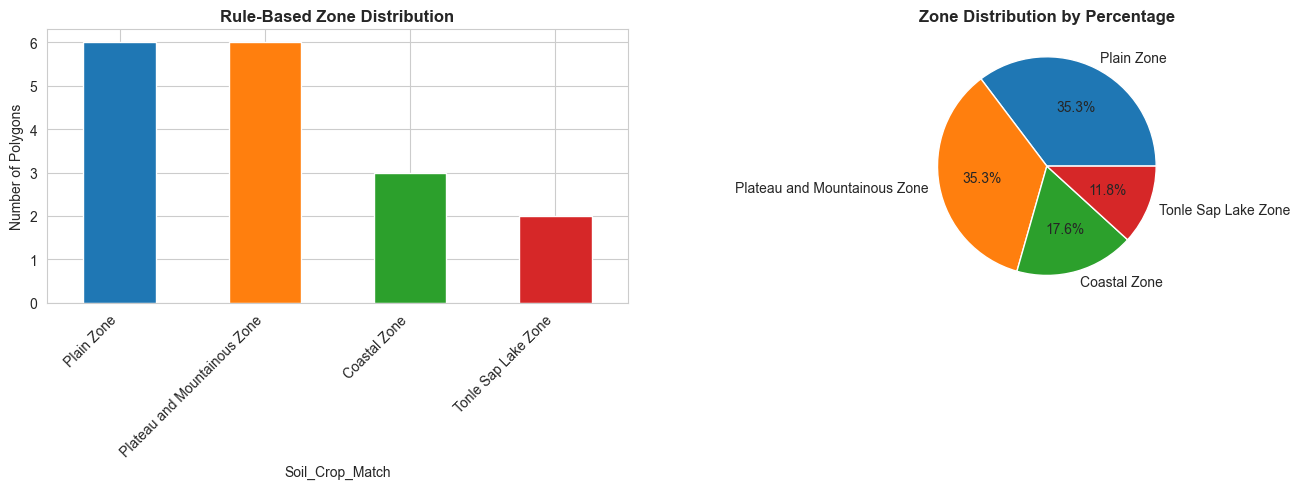

: 

: 

: 

: 

: 

In [ ]:
# Zone distribution visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

zone_counts = gdf_merged["Soil_Crop_Match"].value_counts()
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"]

zone_counts.plot(kind="bar", ax=ax1, color=colors[: len(zone_counts)])
ax1.set_title("Rule-Based Zone Distribution", fontsize=12, fontweight="bold")
ax1.set_ylabel("Number of Polygons")
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha="right")

zone_pct = gdf_merged["Soil_Crop_Match"].value_counts(normalize=True) * 100
ax2.pie(
    zone_pct, labels=zone_pct.index, autopct="%1.1f%%", colors=colors[: len(zone_pct)]
)
ax2.set_title("Zone Distribution by Percentage", fontsize=12, fontweight="bold")

plt.tight_layout()
plt.show()

##  11: Machine Learning - K-Means Clustering

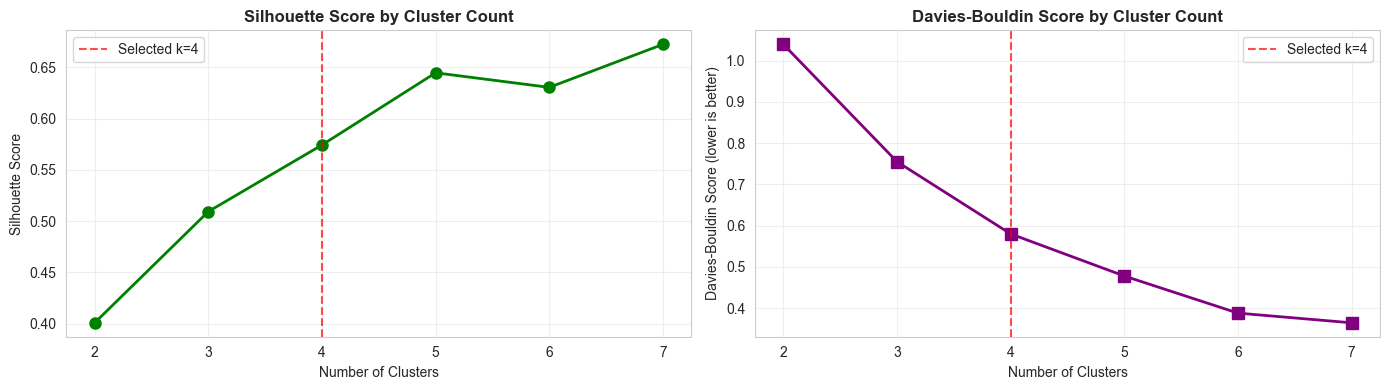

K-Means model trained (k=4)
Silhouette Score: 0.5743
Davies-Bouldin Score: 0.5797


: 

: 

: 

: 

: 

In [ ]:
# Prepare data for clustering
X = gdf_merged[numeric_cols].copy()

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Evaluate optimal number of clusters using silhouette score
silhouette_scores = []
davies_bouldin_scores = []
cluster_range = range(2, 8)

for k in cluster_range:
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans_temp.fit_predict(X_scaled)
    silhouette_scores.append(silhouette_score(X_scaled, labels))
    davies_bouldin_scores.append(davies_bouldin_score(X_scaled, labels))

# Plot evaluation metrics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

ax1.plot(
    cluster_range,
    silhouette_scores,
    marker="o",
    linewidth=2,
    markersize=8,
    color="green",
)
ax1.axvline(4, color="red", linestyle="--", alpha=0.7, label="Selected k=4")
ax1.set_xlabel("Number of Clusters")
ax1.set_ylabel("Silhouette Score")
ax1.set_title("Silhouette Score by Cluster Count", fontweight="bold")
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(
    cluster_range,
    davies_bouldin_scores,
    marker="s",
    linewidth=2,
    markersize=8,
    color="purple",
)
ax2.axvline(4, color="red", linestyle="--", alpha=0.7, label="Selected k=4")
ax2.set_xlabel("Number of Clusters")
ax2.set_ylabel("Davies-Bouldin Score (lower is better)")
ax2.set_title("Davies-Bouldin Score by Cluster Count", fontweight="bold")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Train final K-Means model with k=4
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
gdf_merged["Cluster_Label"] = kmeans.fit_predict(X_scaled)

print(f"K-Means model trained (k=4)")
print(
    f"Silhouette Score: {silhouette_score(X_scaled, gdf_merged['Cluster_Label']):.4f}"
)
print(
    f"Davies-Bouldin Score: {davies_bouldin_score(X_scaled, gdf_merged['Cluster_Label']):.4f}"
)

##  12: Automated Cluster Interpretation

In [ ]:
# Type hints for Pylance: gdf_merged is GeoDataFrame from Cell 6, numeric_cols is list from Cell 6
# Analyze cluster characteristics using all 3 crops
cluster_profiles = gdf_merged.groupby("Cluster_Label")[numeric_cols].mean()
global_means = gdf_merged[numeric_cols].mean()

display(cluster_profiles.round(2))

# Dynamic cluster labeling - enhanced with all 3 crops
cluster_mapping = {}
for cluster_id in cluster_profiles.index:
    row = cluster_profiles.loc[cluster_id]
    ratios = {
        "Rice Bowl Zone": (
            row["Rice_Yield_Ton_Ha"] / global_means["Rice_Yield_Ton_Ha"]
            if global_means["Rice_Yield_Ton_Ha"] > 0
            else 0
        ),
        "Industrial Crop Zone": (
            row["Cassava_Yield_Ton_Ha"] / global_means["Cassava_Yield_Ton_Ha"]
            if global_means["Cassava_Yield_Ton_Ha"] > 0
            else 0
        ),
        "Fruit Hub": (
            row["Mango_Density"] / global_means["Mango_Density"]
            if global_means["Mango_Density"] > 0
            else 0
        ),
    }
    max_feature = max(ratios, key=ratios.get)
    cluster_mapping[cluster_id] = (
        max_feature if ratios[max_feature] >= 1.0 else "Multi-Crop Zone"
    )

gdf_merged["Cluster_Name"] = gdf_merged["Cluster_Label"].map(cluster_mapping)

print("Cluster Mapping (3-Crop Analysis):")
for cluster_id, label in sorted(cluster_mapping.items()):
    cluster_row = cluster_profiles.loc[cluster_id]
    ratios_display = {
        "Rice Bowl Zone": (
            cluster_row["Rice_Yield_Ton_Ha"] / global_means["Rice_Yield_Ton_Ha"]
            if global_means["Rice_Yield_Ton_Ha"] > 0
            else 0
        ),
        "Industrial Crop Zone": (
            cluster_row["Cassava_Yield_Ton_Ha"] / global_means["Cassava_Yield_Ton_Ha"]
            if global_means["Cassava_Yield_Ton_Ha"] > 0
            else 0
        ),
        "Fruit Hub": (
            cluster_row["Mango_Density"] / global_means["Mango_Density"]
            if global_means["Mango_Density"] > 0
            else 0
        ),
    }
    top_crops = sorted(
        [(k, v) for k, v in ratios_display.items()], key=lambda x: x[1], reverse=True
    )[:3]
    print(f"  Cluster {cluster_id}: {label}")
    print(
        "    Top 3 crops: "
        + ", ".join(
            f"{crop.replace(' Zone', '')}: {ratio:.2f}x" for crop, ratio in top_crops
        )
    )

Rice_Yield_Ton_Ha  Cassava_Yield_Ton_Ha  Mango_Density
Cluster_Label                                                        
0                           3.25                 14.85          37.53
1                           2.73                 11.37          40.85
2                           3.74                 11.12          60.27
3                           4.18                 13.13          31.67

Cluster Mapping (3-Crop Analysis):
  Cluster 0: Industrial Crop Zone
    Top 3 crops: Industrial Crop: 1.24x, Rice Bowl: 0.95x, Fruit Hub: 0.82x
  Cluster 1: Multi-Crop Zone
    Top 3 crops: Industrial Crop: 0.95x, Fruit Hub: 0.89x, Rice Bowl: 0.80x
  Cluster 2: Fruit Hub
    Top 3 crops: Fruit Hub: 1.32x, Rice Bowl: 1.10x, Industrial Crop: 0.93x
  Cluster 3: Rice Bowl Zone
    Top 3 crops: Rice Bowl: 1.23x, Industrial Crop: 1.09x, Fruit Hub: 0.69x


: 

: 

: 

: 

: 

##  13: Advanced Visualization - PCA Analysis

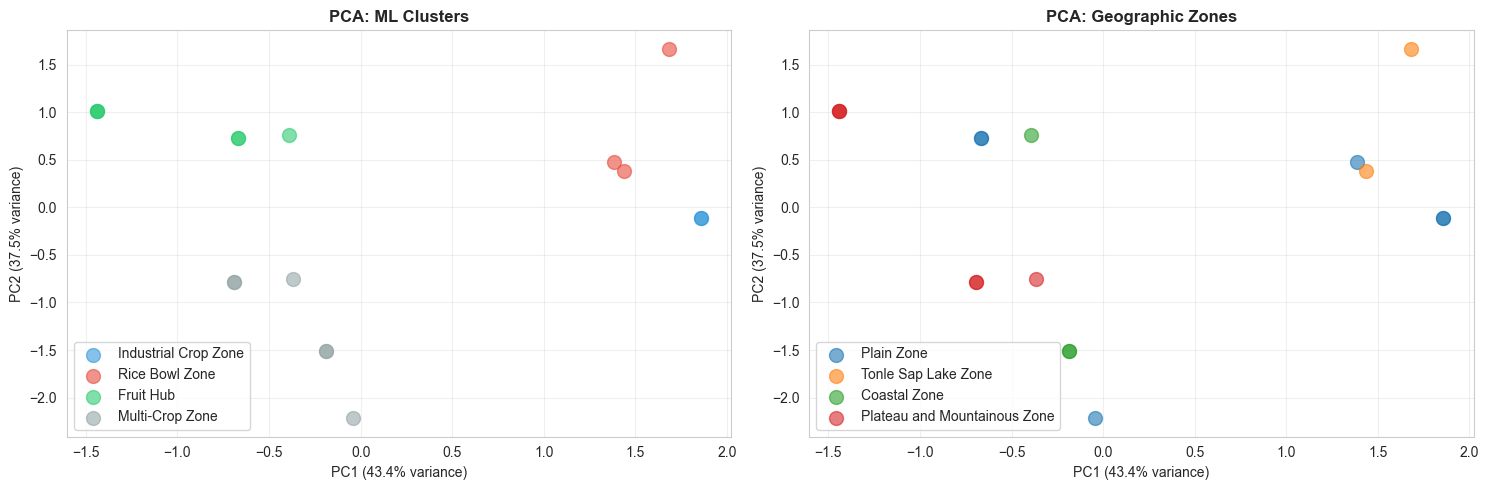

Explained Variance: PC1=43.4%, PC2=37.5%


: 

: 

: 

: 

: 

In [ ]:
# Type hints for Pylance: gdf_merged (GeoDataFrame), X_scaled (ndarray), numeric_cols (list)
# Principal Component Analysis for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# PCA by ML clusters - comprehensive color scheme for all cluster types
cluster_colors = {
    "Rice Bowl Zone": "#e74c3c",
    "Industrial Crop Zone": "#3498db",
    "Fruit Hub": "#2ecc71",
    "Multi-Crop Zone": "#95a5a6",
}
for cluster in gdf_merged["Cluster_Name"].unique():
    mask = gdf_merged["Cluster_Name"] == cluster
    axes[0].scatter(
        X_pca[mask, 0],
        X_pca[mask, 1],
        label=cluster,
        s=100,
        alpha=0.6,
        color=cluster_colors.get(cluster, "#808080"),
    )
axes[0].set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)")
axes[0].set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)")
axes[0].set_title("PCA: ML Clusters", fontweight="bold")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# PCA by rule-based zones - FIXED: Match actual geographic zone names
zone_colors = {
    "Plain Zone": "#1f77b4",
    "Tonle Sap Lake Zone": "#ff7f0e",
    "Coastal Zone": "#2ca02c",
    "Plateau and Mountainous Zone": "#d62728",
}
for zone in gdf_merged["Soil_Crop_Match"].unique():
    mask = gdf_merged["Soil_Crop_Match"] == zone
    axes[1].scatter(
        X_pca[mask, 0],
        X_pca[mask, 1],
        label=zone,
        s=100,
        alpha=0.6,
        color=zone_colors.get(zone, "#808080"),
    )
axes[1].set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)")
axes[1].set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)")
axes[1].set_title("PCA: Geographic Zones", fontweight="bold")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(
    f"Explained Variance: PC1={pca.explained_variance_ratio_[0]:.1%}, PC2={pca.explained_variance_ratio_[1]:.1%}"
)

##  14: Cross-Analysis - Expert vs. Machine Learning Agreement

Cluster_Name                  Fruit Hub  Industrial Crop Zone  \
Soil_Crop_Match                                                 
Coastal Zone                          1                     0   
Plain Zone                            2                     2   
Plateau and Mountainous Zone          3                     0   
Tonle Sap Lake Zone                   0                     0   

Cluster_Name                  Multi-Crop Zone  Rice Bowl Zone  
Soil_Crop_Match                                                
Coastal Zone                                2               0  
Plain Zone                                  1               1  
Plateau and Mountainous Zone                3               0  
Tonle Sap Lake Zone                         0               2

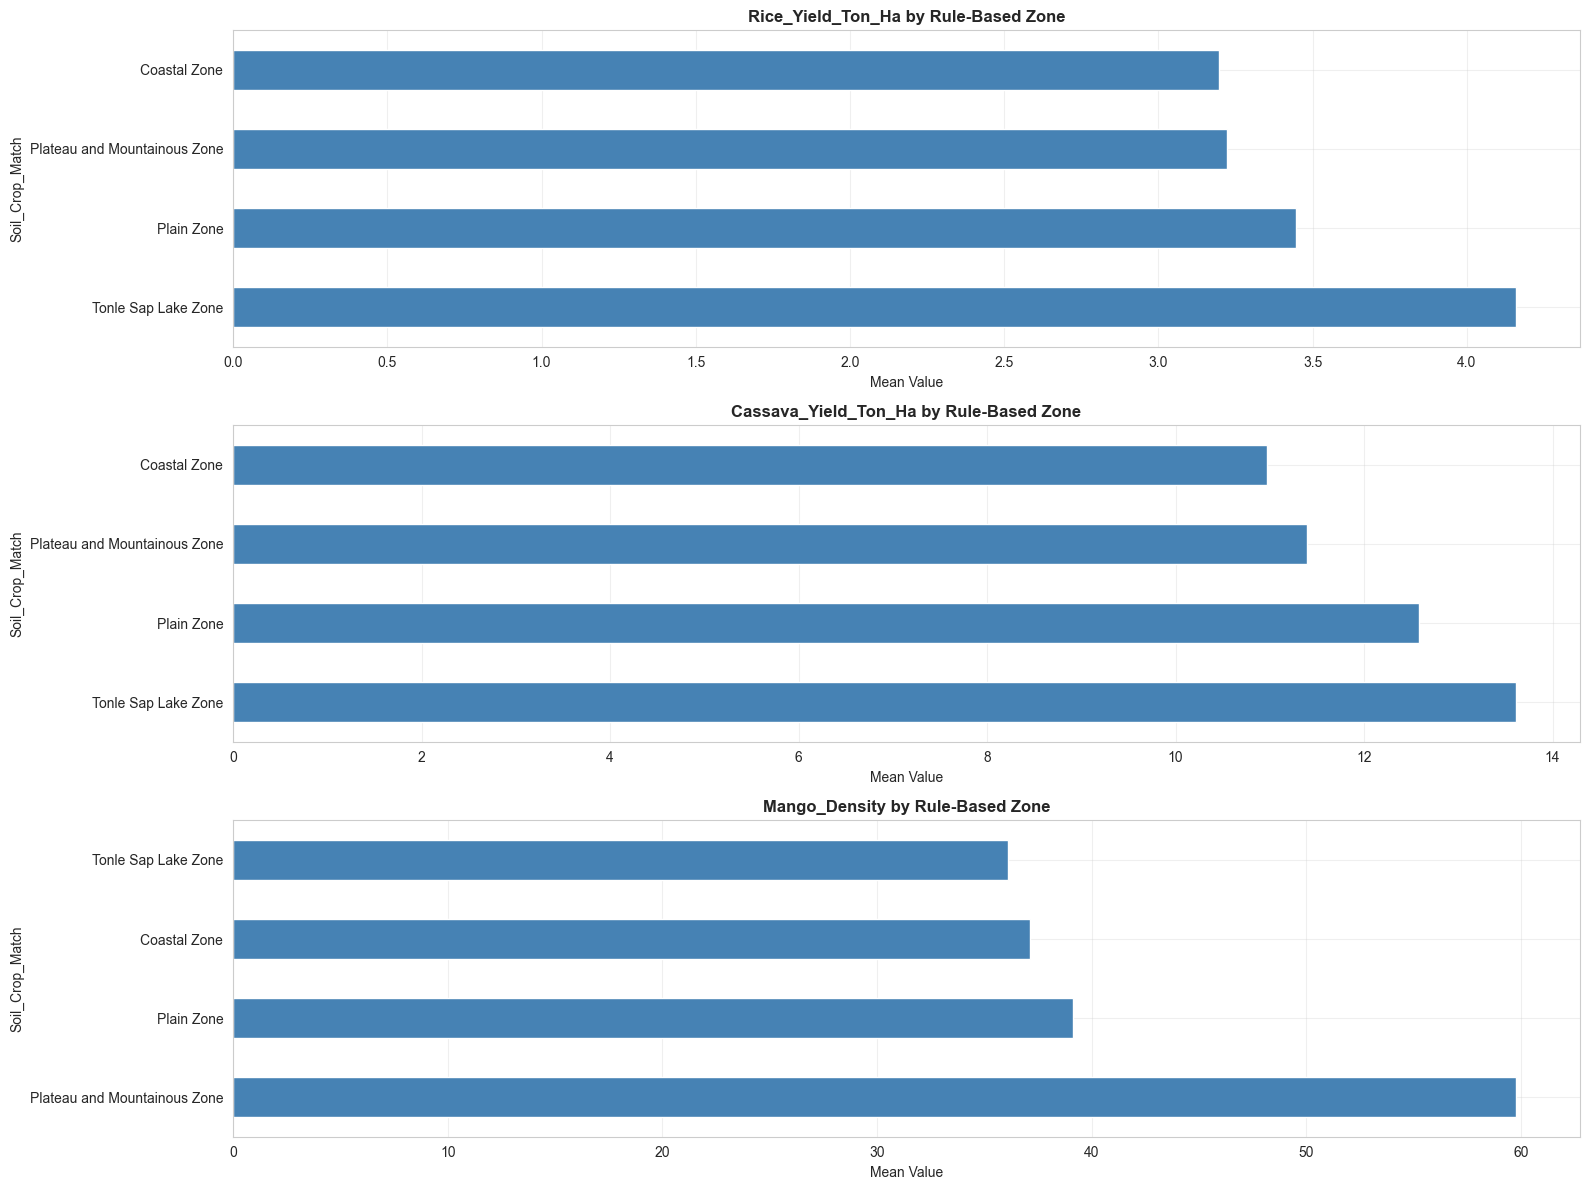

: 

: 

: 

: 

: 

In [ ]:
# Type hints for Pylance: gdf_merged (GeoDataFrame), numeric_cols (list), pd (DataFrame)
# Compare rule-based and ML classifications
comparison_matrix = pd.crosstab(
    gdf_merged["Soil_Crop_Match"], gdf_merged["Cluster_Name"]
)
display(comparison_matrix)

# Feature importance by zone - all 3 crops
fig, axes = plt.subplots(3, 1, figsize=(16, 12))

for idx, col in enumerate(numeric_cols):
    ax = axes[idx]
    zone_means = (
        gdf_merged.groupby("Soil_Crop_Match")[col].mean().sort_values(ascending=False)
    )
    zone_means.plot(kind="barh", ax=ax, color="steelblue")
    ax.set_title(f"{col} by Rule-Based Zone", fontweight="bold")
    ax.set_xlabel("Mean Value")
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

##  15: Interactive Geographic Visualization

In [ ]:
cambodia_center = [12.5, 104.9]
base_map = folium.Map(location=cambodia_center, zoom_start=7, tiles="OpenStreetMap")

# Define geographic zone provinces
geographic_zones = {
    "Plain Zone": [
        "Phnom Penh",
        "Kandal",
        "Prey Veng",
        "Svay Rieng",
        "Takeo",
        "Kampong Cham",
        "Tboung Khmum",
        "Kampong Speu",
    ],
    "Tonle Sap Lake Zone": [
        "Siem Reap",
        "Battambang",
        "Pursat",
        "Kampong Chhnang",
        "Kampong Thom",
        "Banteay Meanchey",
        "Pailin",
    ],
    "Coastal Zone": ["Koh Kong", "Preah Sihanouk", "Kampot", "Kep"],
    "Plateau and Mountainous Zone": [
        "Ratanakiri",
        "Mondulkiri",
        "Kratie",
        "Stung Treng",
        "Preah Vihear",
        "Oddar Meanchey",
    ],
}

# Define color schemes - FIXED: Match actual zone names from classify_soil_crop_match()
rule_colors = {
    "Plain Zone": "#1f77b4",
    "Tonle Sap Lake Zone": "#ff7f0e",
    "Coastal Zone": "#2ca02c",
    "Plateau and Mountainous Zone": "#d62728",
}

# FIXED: Added "Multi-Crop Zone" which can be assigned by cluster mapping
ml_colors = {
    "Rice Bowl Zone": "#e74c3c",
    "Industrial Crop Zone": "#3498db",
    "Fruit Hub": "#2ecc71",
    "Multi-Crop Zone": "#95a5a6",  # Added: for clusters with no dominant crop
}

# Add Rule-Based Zones Layer
feature_group_zones = folium.FeatureGroup(name="Geographic Zones")

for _, row in gdf_merged.iterrows():
    # Get color based on zone
    zone = row["Soil_Crop_Match"]
    color = rule_colors.get(zone, "#808080")  # Default grey

    # Create popup content
    popup_html = f"""
    <div style="font-family: Arial; width: 200px;">
        <h4>{row['Province_Name']}</h4>
        <b>Zone:</b> {zone}<br>
        <b>Soil Type:</b> {row['Soil_Type']}<br>
        <hr>
        <b>Rice Yield:</b> {row['Rice_Yield_Ton_Ha']:.2f} t/ha<br>
        <b>Cassava Yield:</b> {row['Cassava_Yield_Ton_Ha']:.2f} t/ha<br>
        <b>Mango Density:</b> {row['Mango_Density']:.2f}
    </div>
    """

    # Add polygon
    if row["geometry"] is not None:
        if row["geometry"].geom_type == "Polygon":
            coords = [[p[1], p[0]] for p in row["geometry"].exterior.coords]
            folium.Polygon(
                locations=coords,
                color=color,
                weight=1,
                fill=True,
                fill_color=color,
                fill_opacity=0.6,
                popup=folium.Popup(popup_html, max_width=300),
                tooltip=f"{zone} - {row['Province_Name']}",
            ).add_to(feature_group_zones)
        elif row["geometry"].geom_type == "MultiPolygon":
            for poly in row["geometry"].geoms:
                coords = [[p[1], p[0]] for p in poly.exterior.coords]
                folium.Polygon(
                    locations=coords,
                    color=color,
                    weight=1,
                    fill=True,
                    fill_color=color,
                    fill_opacity=0.6,
                    popup=folium.Popup(popup_html, max_width=300),
                    tooltip=f"{zone} - {row['Province_Name']}",
                ).add_to(feature_group_zones)

feature_group_zones.add_to(base_map)

# Add Layer Control
folium.LayerControl().add_to(base_map)

# Add Legend (HTML)
legend_html = """
<div style="position: fixed; 
     bottom: 50px; left: 50px; width: 220px; height: 130px; 
     border:2px solid grey; z-index:9999; font-size:14px;
     background-color:white; opacity:0.9; padding: 10px;">
     <b>Geographic Zones</b> <br>
     <i class="fa fa-square" style="color:#1f77b4"></i> Plain Zone<br>
     <i class="fa fa-square" style="color:#ff7f0e"></i> Tonle Sap Lake Zone<br>
     <i class="fa fa-square" style="color:#2ca02c"></i> Coastal Zone<br>
     <i class="fa fa-square" style="color:#d62728"></i> Plateau & Mountain<br>
</div>
"""
base_map.get_root().html.add_child(folium.Element(legend_html))

# Display map
display(base_map)

: 

: 

: 

: 

: 

In [ ]:
## output map geographic zones of Cambodia with soil suitability and crop production display as table

: 

: 

: 

: 

: 

##  16: Results Export & Documentation

In [ ]:
# Type hints for Pylance: base_path (Path), gdf_merged (GeoDataFrame), numeric_cols (list)
# Export results to multiple formats
export_cols = [
    "Soil_Type",
    "Province_Name",
    "Rice_Yield_Ton_Ha",
    "Cassava_Yield_Ton_Ha",
    "Mango_Density",
    "Soil_Crop_Match",
    "Cluster_Label",
    "Cluster_Name",
]

# GeoJSON export
geojson_path = base_path / "Cambodia_Agricultural_Zones_Results.geojson"
gdf_merged.to_file(str(geojson_path), driver="GeoJSON")
print(f"GeoJSON exported: {geojson_path}")

# CSV export
csv_path = base_path / "Cambodia_Agricultural_Zones_Analysis.csv"
gdf_merged[export_cols].to_csv(str(csv_path), index=False)
print(f"CSV exported: {csv_path}")

# Summary statistics
summary = gdf_merged.groupby("Soil_Crop_Match")[numeric_cols].agg(
    ["mean", "min", "max"]
)
display(summary.round(2))

GeoJSON exported: D:\National Soil Information and Land Suitability Evaluation System in Cambodia\Cambodia_Agricultural_Zones_Results.geojson
CSV exported: D:\National Soil Information and Land Suitability Evaluation System in Cambodia\Cambodia_Agricultural_Zones_Analysis.csv


Rice_Yield_Ton_Ha              \
                                          mean   min   max   
Soil_Crop_Match                                              
Coastal Zone                              3.20  2.81  3.96   
Plain Zone                                3.45  2.54  4.23   
Plateau and Mountainous Zone              3.22  2.62  3.70   
Tonle Sap Lake Zone                       4.16  3.92  4.40   

                             Cassava_Yield_Ton_Ha               Mango_Density  \
                                             mean    min    max          mean   
Soil_Crop_Match                                                                 
Coastal Zone                                10.97  10.92  11.06         37.11   
Plain Zone                                  12.58  10.70  14.85         39.11   
Plateau and Mountainous Zone                11.40  10.91  12.62         59.76   
Tonle Sap Lake Zone                         13.61  13.06  14.16         36.11   

                                            
                                min    max  
Soil_Crop_Match                             
Coastal Zone                  31.98  47.36  
Plain Zone                    22.79  56.45  
Plateau and Mountainous Zone  50.85  67.11  
Tonle Sap Lake Zone           30.23  41.98

: 

: 

: 

: 

: 

##  17: Final Report & Key Insights

In [ ]:
# Type hints for Pylance: gdf_merged (GeoDataFrame), pd (DataFrame), numeric_cols (list)
# Generate comprehensive summary
report_data = []

for zone in sorted(gdf_merged["Soil_Crop_Match"].unique()):
    zone_data = gdf_merged[gdf_merged["Soil_Crop_Match"] == zone]
    report_data.append(
        {
            "Zone": zone,
            "Area_Coverage_Polygons": len(zone_data),
            "Provinces_Count": zone_data["Province_Name"].nunique(),
            "Avg_Rice_Yield_t_ha": zone_data["Rice_Yield_Ton_Ha"].mean(),
            "Avg_Cassava_Yield_t_ha": zone_data["Cassava_Yield_Ton_Ha"].mean(),
        }
    )

report_df = pd.DataFrame(report_data).set_index("Zone")
display(report_df.round(2))

# Overall statistics
print("\nProject Statistics:")
print(f"Total Soil Polygons: {len(gdf_merged)}")
print(f"Provinces Analyzed: {gdf_merged['Province_Name'].nunique()}")
print(f"Soil Types Identified: {gdf_merged['Soil_Type'].nunique()}")
print(f"Rule-Based Zones: {gdf_merged['Soil_Crop_Match'].nunique()}")
print(f"ML Clusters: {gdf_merged['Cluster_Name'].nunique()}")
print(f"\nCoordinate Reference System: {gdf_merged.crs}")

Area_Coverage_Polygons  Provinces_Count  \
Zone                                                                    
Coastal Zone                                       3                2   
Plain Zone                                         6                4   
Plateau and Mountainous Zone                       6                3   
Tonle Sap Lake Zone                                2                2   

                              Avg_Rice_Yield_t_ha  Avg_Cassava_Yield_t_ha  
Zone                                                                       
Coastal Zone                                 3.20                   10.97  
Plain Zone                                   3.45                   12.58  
Plateau and Mountainous Zone                 3.22                   11.40  
Tonle Sap Lake Zone                          4.16                   13.61


Project Statistics:
Total Soil Polygons: 17
Provinces Analyzed: 11
Soil Types Identified: 17
Rule-Based Zones: 4
ML Clusters: 4

Coordinate Reference System: EPSG:4326


: 

: 

: 

: 

: 